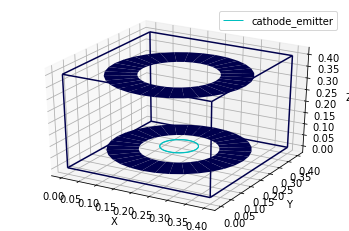

In [3]:
%matplotlib inline
from ef.config.config import Config
from ef.config.visualizer import Visualizer3d
conf = Config.from_fname('pot.conf')
conf.visualize_all(Visualizer3d())

In [8]:
sim = conf.make()
sim.start_pic_simulation()

Writing initial fields to file
Writing to file pot_fieldsWithoutParticles_new.h5
Writing to file pot_fieldsWithoutParticles.h5
Writing step 0 to file
Writing to file pot_0000000_new.h5
Writing to file pot_0000000.h5
Time step from 0 to 1 of 101
Time step from 1 to 2 of 101
Time step from 2 to 3 of 101
Time step from 3 to 4 of 101
Time step from 4 to 5 of 101
Time step from 5 to 6 of 101
Time step from 6 to 7 of 101
Time step from 7 to 8 of 101
Time step from 8 to 9 of 101
Time step from 9 to 10 of 101
Time step from 10 to 11 of 101
Time step from 11 to 12 of 101
Time step from 12 to 13 of 101
Time step from 13 to 14 of 101
Time step from 14 to 15 of 101
Time step from 15 to 16 of 101
Time step from 16 to 17 of 101
Time step from 17 to 18 of 101
Time step from 18 to 19 of 101
Time step from 19 to 20 of 101
Time step from 20 to 21 of 101
Time step from 21 to 22 of 101
Time step from 22 to 23 of 101
Time step from 23 to 24 of 101
Time step from 24 to 25 of 101
Time step from 25 to 26 of 1

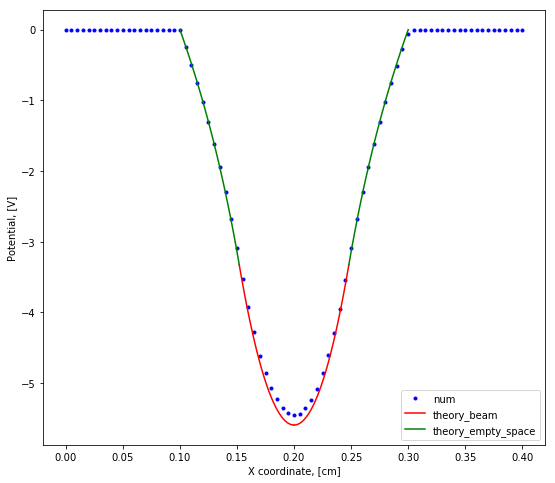

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def get_source_parameters(sim):
    radius_beam = sim.particle_sources[0].shape.radius
    charge = sim.particle_sources[0].charge
    mass = sim.particle_sources[0].mass
    momentum_z = sim.particle_sources[0].mean_momentum[2]
    particle_per_step = sim.particle_sources[0].particles_to_generate_each_step
    time_step = sim.time_grid.time_step_size
    radius_tube = sim.inner_regions[0].shape.inner_radius
    return radius_beam, charge, mass, momentum_z, particle_per_step, time_step, radius_tube


def get_mesh_parameters(sim):
    data = {c: sim.spat_mesh.node_coordinates[..., i].flatten() for i, c in enumerate('xyz')}
    data['pot'] = sim.spat_mesh.potential.flatten()
    return pd.DataFrame.from_dict(data)


def get_beam_parameters(sim):
    beam_center_x = sim.particle_sources[0].shape.end[0]
    beam_middle_z = sim.spat_mesh.node_coordinates[0, 0, sim.spat_mesh.n_nodes[2]//2, 2]
    return beam_center_x, beam_middle_z


def evaluate_velocity_current_square(radius_beam, charge, mass, momentum_z, particle_per_step, time_step):
    ampere_to_cgs = 2997924536.8431
    velocity = momentum_z / mass
    current = particle_per_step * charge / time_step / ampere_to_cgs
    square = radius_beam ** 2 * np.pi
    return velocity, current, square


def evaluate_k_const(velocity, current, square):
    k_const = 2.85e+12 * current / velocity / square
    return k_const


sgse_to_volts = 300

pot = get_mesh_parameters(sim)

beam_center_x, beam_middle_z = get_beam_parameters(sim)
radius_beam, charge, mass, momentum_z, particle_per_step, time_step, radius_tube = get_source_parameters(sim)
velocity, current, square = evaluate_velocity_current_square(radius_beam, charge, mass, momentum_z, particle_per_step,
                                                             time_step)
k_const = evaluate_k_const(velocity, current, square)

R_beam = np.linspace(0, radius_beam, 100)
R_empty = np.linspace(radius_beam, radius_tube, 100)
phi_beam = -k_const * (R_beam ** 2 - radius_beam ** 2 * (1 - 2 * np.log(radius_beam / radius_tube)))
phi_empty = -2 * k_const * radius_beam ** 2 * np.log(R_empty / radius_tube)

pot = pot.where(pot.x == beam_center_x)
pot = pot.where(pot.z == beam_middle_z)
plt.xlabel("X coordinate, [cm]")
plt.ylabel("Potential, [V]")
plt.plot(pot.y, pot.pot * sgse_to_volts, '.', color="blue", label="num")
plt.plot(R_beam + beam_center_x, phi_beam, color='r', label="theory_beam")
plt.plot(-1 * R_beam + beam_center_x, phi_beam, color='r')
plt.plot(R_empty + beam_center_x, phi_empty, color='g', label="theory_empty_space")
plt.plot(-1 * R_empty + beam_center_x, phi_empty, color='g')
plt.legend(loc='lower right')
#plt.savefig("pot.png")
